<a href="https://colab.research.google.com/github/oppachar/face-recognition-_jisong/blob/main/face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive    # 드라이브 마운팅
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 필요한 라이브러리 설치하기
!git clone https://github.com/ndb796/bing_image_downloader


fatal: destination path 'bing_image_downloader' already exists and is not an empty directory.


In [3]:
# 한글 폰트 설치하기 (꼭! 설치가 완료되면 [런타임 다시 시작]을 누르고 다시 실행하기)
!apt install fonts-nanum -y

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정하기
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
plt.rc('font', family='NanumBarunGothic')
matplotlib.font_manager._rebuild()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [4]:
import os
import shutil
from bing_image_downloader import downloader


directory_list = [
    '/content/drive/MyDrive/Colab Notebooks/custom_dataset/train/',
    '/content/drive/MyDrive/Colab Notebooks/custom_dataset/test/',
]

# 초기 디렉토리 만들기
for directory in directory_list:
    if not os.path.isdir(directory):
        os.mkdir(directory)

# 수집한 이미지를 학습 데이터와 평가 데이터로 구분하는 함수
def dataset_split(query, train_cnt):
    # 학습 및 평가 데이터셋 디렉토리 만들기
    for directory in directory_list:
        if not os.path.isdir(directory + '/' + query):
            os.mkdir(directory + '/' + query)
    # 학습 및 평가 데이터셋 준비하기
    cnt = 0
    for file_name in os.listdir(query):
        if cnt < train_cnt:
            print(f'[Train Dataset] {file_name}')
            shutil.move(query + '/' + file_name, '/content/drive/MyDrive/Colab Notebooks/custom_dataset/train/' + query + '/' + file_name)
        else:
            print(f'[Test Dataset] {file_name}')
            shutil.move(query + '/' + file_name, '/content/drive/MyDrive/Colab Notebooks/custom_dataset/test/' + query + '/' + file_name)
        cnt += 1
    shutil.rmtree(query)

In [5]:
query = '계란형 얼굴'
downloader.download(query, limit=40,  output_dir='./', adult_filter_off=True, force_replace=False, timeout=60)
dataset_split(query, 30)



[!!]Indexing page: 1

[%] Indexed 10 Images on Page 1.


[%] Downloading Image #1 from http://blogfiles.naver.net/20130329_297/happyntour_1364523017370lHuLX_JPEG/2013-03-29_10%3B56%3B32.jpg
[%] File Downloaded !

[%] Downloading Image #2 from http://blogfiles.naver.net/20130329_22/happyntour_1364523372896cEPTt_JPEG/2013-03-29_09%3B41%3B25.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://t1.daumcdn.net/cfile/tistory/224AE941577145CC24


KeyboardInterrupt: ignored

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import time


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체


In [7]:
if torch.cuda.is_available():
  print("available")

available


In [8]:
!nvidia-smi 

Fri May  7 05:37:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = '/content/drive/MyDrive/Colab Notebooks/custom_dataset'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=6, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=6, shuffle=True, num_workers=4)

print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)


학습 데이터셋 크기: 289
테스트 데이터셋 크기: 75
클래스: ['각진형', '계란형', '둥근형', '마름모형', '하트형']


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [10]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4352 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4357 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-pack

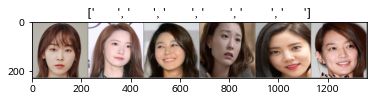

tensor([1, 1, 2, 0, 3, 4])


In [11]:
def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # 이미지 출력
    plt.imshow(input)
    plt.title(title)
    plt.show()



# 학습 데이터를 배치 단위로 불러오기
iterator = iter(train_dataloader)


# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)


out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

print(classes)

In [12]:
model = models.resnet34(pretrained=True)
num_features = model.fc.in_features

# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 5개로 교체하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, 5)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [13]:
num_epochs = 50
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#0 Loss: 1.6181 Acc: 28.3737% Time: 3.0588s
#1 Loss: 1.1775 Acc: 51.2111% Time: 5.9658s
#2 Loss: 0.7255 Acc: 71.9723% Time: 8.9422s
#3 Loss: 0.5353 Acc: 80.6228% Time: 11.9185s
#4 Loss: 0.4288 Acc: 85.8132% Time: 14.8443s
#5 Loss: 0.2517 Acc: 91.6955% Time: 17.7697s
#6 Loss: 0.3517 Acc: 87.1972% Time: 20.7480s
#7 Loss: 0.4549 Acc: 85.1211% Time: 23.6869s
#8 Loss: 0.2496 Acc: 89.2734% Time: 26.6172s
#9 Loss: 0.2428 Acc: 88.9273% Time: 29.5772s
#10 Loss: 0.1864 Acc: 93.7716% Time: 32.5552s
#11 Loss: 0.1981 Acc: 92.7336% Time: 35.5662s
#12 Loss: 0.2597 Acc: 91.3495% Time: 38.5937s
#13 Loss: 0.1468 Acc: 95.1557% Time: 41.5996s
#14 Loss: 0.1639 Acc: 96.1938% Time: 44.6330s
#15 Loss: 0.1149 Acc: 96.5398% Time: 47.6867s
#16 Loss: 0.1606 Acc: 94.1176% Time: 50.7297s
#17 Loss: 0.1546 Acc: 94.4637% Time: 53.7340s
#18 Loss: 0.1309 Acc: 95.5017% Time: 56.7545s
#19 Loss: 0.1097 Acc: 95.8478% Time: 59.7295s
#20 Loss: 0.0834 Acc: 97.2318% Time: 62.7606s
#21 Loss: 0.1437 Acc: 95.5017% Time: 65.7850s
#

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[예측 결과: 각진형] (실제 정답: 각진형)


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4352 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4449 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4520 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4364 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4469 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4523 missing from current font.
  font.set_text(s

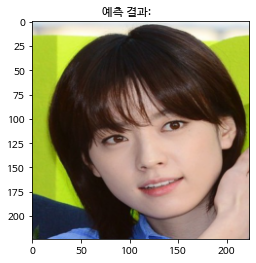

[예측 결과: 마름모형] (실제 정답: 마름모형)


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4358 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4357 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4467 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4535 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 4358 missing from current font.
  font.set_text(s

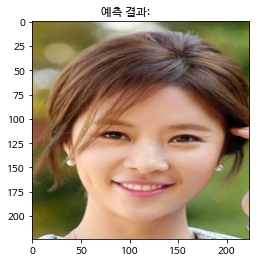

[예측 결과: 계란형] (실제 정답: 계란형)


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 4456 missing from current font.
  font.set_text(s, 0, flags=flags)


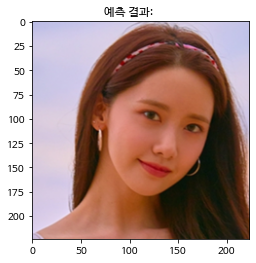

[예측 결과: 계란형] (실제 정답: 각진형)


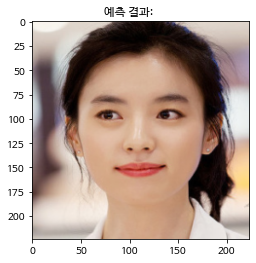

[예측 결과: 둥근형] (실제 정답: 둥근형)


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4355 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4462 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 4355 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 4462 missing from current font.
  font.set_text(s, 0, flags=flags)


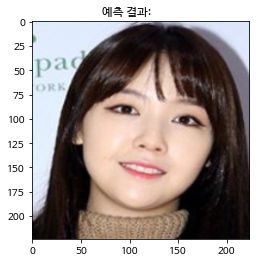

[예측 결과: 계란형] (실제 정답: 각진형)


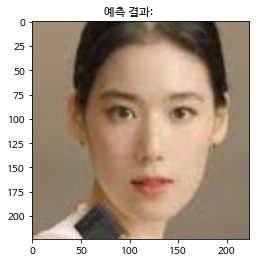

[예측 결과: 마름모형] (실제 정답: 마름모형)


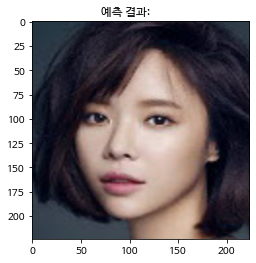

[예측 결과: 각진형] (실제 정답: 각진형)


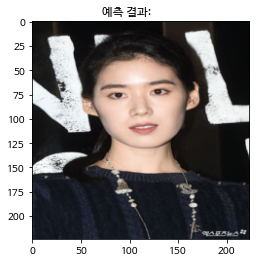

[예측 결과: 각진형] (실제 정답: 각진형)


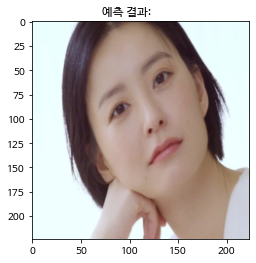

[예측 결과: 각진형] (실제 정답: 마름모형)


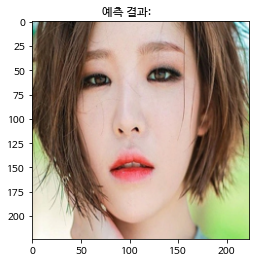

[예측 결과: 둥근형] (실제 정답: 둥근형)


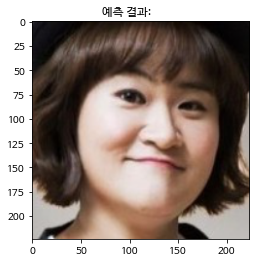

[예측 결과: 둥근형] (실제 정답: 하트형)


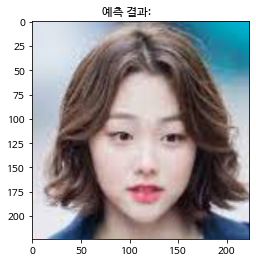

[예측 결과: 계란형] (실제 정답: 계란형)


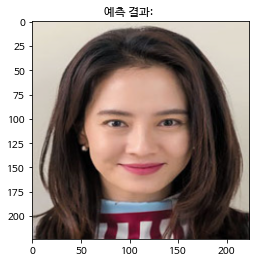

[Test Phase] Loss: 1.5443 Acc: 61.3333% Time: 6.5769s


In [14]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))